# 研究ミーティング 9/22
## やったこと
- Qulacs によるシミュレーション
    - 3 regular (16頂点 & 18頂点) ランダムグラフ(10種類) における MaxCut を 3-1 QRAO で解く。
    - entanglement は linear, compatible, random の 3種類を実行
    - level は 0 (no entanglement) から 9 まで試した。
    - Optimizer は CobylaOptimizer, max_iter=25000
    - Rounding は shot=1000

## 今後の方針
- Pauli rounding をやれば差が出る可能性がある。
- graph の大きさをもっとあげないと差が出ないかも (40node くらい)
- graph の density をあげて試してみる
- weighted にしてみる
- NFT algorithm + EfficientSU2 に移行
    - NFT algorithm for non-EfficientSU2 (論文あり)

- 3,2 にすればビット数が増えるが、近似率は改善するのでは？

## memo
- ハミルトニアンの最小固有値と固有状態を求めてそれをデコードしてみる。(VQE をやらないで)
    - 16, 18 node なら計算可能
    - 今の ansatz が local optimum に入っている可能性
    - VQE で見つかったものが実際の状態と Fidelity でどのくらい離れているかを計算して改めて linear, compatible, random で比較してみる。

- (14, 16, 18, 20) nodes, (3, 4, 5, 6) deg, (0, 1, 2, 3, 4) layer

- rounding の実装がおかしい可能性 (最優先でチェック)

In [89]:
level0_path = "/work/gs54/s54005/qrao_experiment/results/regular/deg3/nodes40/trial0/3-1/compatible/level1.pkl"
level1_path = "/work/gs54/s54005/qrao_experiment/results/regular/deg3/nodes40/trial0/3-1/linear/level1.pkl"
level2_path = "/work/gs54/s54005/qrao_experiment/results/regular/deg3/nodes40/trial0/3-1/random/level1.pkl"

with open(level0_path, "rb") as f:
    level0_data = pickle.load(f)
with open(level1_path, "rb") as f:
    level1_data = pickle.load(f)
with open(level2_path, "rb") as f:
    level2_data = pickle.load(f)

In [99]:
level0_data.keys()

dict_keys(['solution_counts', 'maxcut_values', 'num_qubit', 'num_edge', 'entanglement', 'level', 'optimum_solution', 'cost_history'])

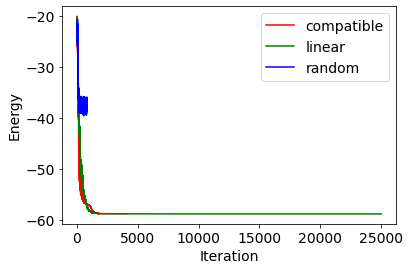

In [90]:
history_0 = level0_data["cost_history"]
history_1 = level1_data["cost_history"]
history_2 = level2_data["cost_history"]

plt.rcParams["font.size"] = 14
plt.plot(history_0, color="red", label="compatible")
plt.plot(history_1, color="green", label="linear")
plt.plot(history_2, color="blue", label="random")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [3]:
import pickle
from networkx import node_link_graph, draw


def load_results(
    deg: int,
    num_nodes: int,
    num_trials: int,
    num_levels: int,
    dir_name: str = "results",
):
    graphs = []
    compatible_results = []
    linear_results = []
    random_results = []
    root_path = f"/work/gs54/s54005/qrao_experiment/{dir_name}/regular/deg{deg}/nodes{num_nodes}/"

    for trial in range(num_trials):
        trial_path = root_path + f"trial{trial}/"
        with open(trial_path + "graph_data.pkl", "rb") as file:
            data = pickle.load(file)
        graph = node_link_data(data)
        graphs.append(graph)
        compatible_result = []
        linear_result = []
        random_result = []
        compatible_root = trial_path + "3-1/compatible/"
        linear_root = trial_path + "3-1/linear/"
        random_root = trial_path + "3-1/random/"

        for level in range(num_levels):
            with open(compatible_root + f"level{level}.pkl", "rb") as file:
                compatible = pickle.load(file)
            with open(linear_root + f"level{level}.pkl", "rb") as file:
                linear = pickle.load(file)
            with open(random_root + f"level{level}.pkl", "rb") as file:
                random = pickle.load(file)
            compatible_result.append(compatible)
            linear_result.append(linear)
            random_result.append(random)

        compatible_results.append(compatible_result)
        linear_results.append(linear_result)
        random_results.append(random_result)

    return graphs, compatible_results, linear_results, random_results

In [4]:
def calc_exp(maxcut_values):
    shots = 1000
    sum_val = 0
    for key, val in maxcut_values.items():
        sum_val += key * val
    return sum_val / shots


def get_mean(values):
    values_mean = []
    for level in range(len(values[0])):
        sum_val = 0
        for instance in range(len(values)):
            sum_val += values[instance][level]
        sum_val /= len(values)
        values_mean.append(sum_val)
    return values_mean

In [ ]:
graphs_dict = {}
compatible_results_dict = {}
linear_results_dict = {}
random_results_dict = {}

degs = [3]
num_nodes_list = [14]
num_trials = 1
num_levels = 5
dir_name = "results"

for deg in degs:
    for num_nodes in num_nodes_list:
        graphs, compatible_results, linear_results, random_results = load_results(
            deg, num_nodes, num_trials, num_levels, dir_name
        )
        graphs_dict[deg][num_nodes] = graphs
        compatible_results_dict[deg][num_nodes] = compatible_results
        linear_results_dict[deg][num_nodes] = linear_results
        random_results_dict[deg][num_nodes] = random_results

In [5]:
def calc_statistics(
    graphs_dict,
    compatible_results_dict,
    linear_results_dict,
    random_results_dict,
    deg,
    num_nodes,
):
    compatible_values_max = []
    linear_values_max = []
    random_values_max = []
    compatible_values_exp = []
    linear_values_exp = []
    random_values_exp = []
    compatible_values_freq = []
    linear_values_freq = []
    random_values_freq = []
    opt_values = []

    graphs = graphs_dict[deg][num_nodes]
    compatible_results = compatible_results_dict[deg][num_nodes]
    linear_results = linear_results_dict[deg][num_nodes]
    random_results = random_results_dict[deg][num_nodes]

    # iteration for instances
    for graph, compatible_result, linear_result, random_result in zip(
        graphs, compatible_results, linear_results, random_results
    ):
        opt_value = -1
        compatible_value_max = []
        linear_value_max = []
        random_value_max = []
        compatible_value_exp = []
        linear_value_exp = []
        random_value_exp = []
        compatible_value_freq = []
        linear_value_freq = []
        random_value_freq = []

        # iteration for levels
        for compatible, linear, random in zip(
            compatible_result, linear_result, random_result
        ):
            compatible_maxcut_max = max(list(compatible["maxcut_values"].keys()))
            linear_maxcut_max = max(list(linear["maxcut_values"].keys()))
            random_maxcut_max = max(list(random["maxcut_values"].keys()))
            compatible_maxcut_exp = calc_exp(compatible["maxcut_values"])
            linear_maxcut_exp = calc_exp(linear["maxcut_values"])
            random_maxcut_exp = calc_exp(random["maxcut_values"])
            compatible_maxcut_freq = list(compatible["maxcut_values"].keys())[0]
            linear_maxcut_freq = list(linear["maxcut_values"].keys())[0]
            random_maxcut_freq = list(random["maxcut_values"].keys())[0]
            assert (
                compatible["optimum_solution"]
                == linear["optimum_solution"]
                == random["optimum_solution"]
            )
            assert opt_value == -1 or opt_value == compatible["optimum_solution"]
            opt_value = max(opt_value, compatible["optimum_solution"])
            compatible_value_max.append(compatible_maxcut_max)
            linear_value_max.append(linear_maxcut_max)
            random_value_max.append(random_maxcut_max)
            compatible_value_exp.append(compatible_maxcut_exp)
            linear_value_exp.append(linear_maxcut_exp)
            random_value_exp.append(random_maxcut_exp)
            compatible_value_freq.append(compatible_maxcut_freq)
            linear_value_freq.append(linear_maxcut_freq)
            random_value_freq.append(random_maxcut_freq)

        compatible_values_max.append(compatible_value_max)
        linear_values_max.append(linear_value_max)
        random_values_max.append(random_value_max)
        compatible_values_exp.append(compatible_value_exp)
        linear_values_exp.append(linear_value_exp)
        random_values_exp.append(random_value_exp)
        compatible_values_freq.append(compatible_value_freq)
        linear_values_freq.append(linear_value_freq)
        random_values_freq.append(random_value_freq)
        opt_values.append(opt_value)

    return (
        compatible_values_max,
        linear_values_max,
        random_values_max,
        compatible_values_exp,
        linear_values_exp,
        random_values_exp,
        compatible_values_freq,
        linear_values_freq,
        random_values_freq,
        opt_values,
    )

In [87]:
compatible_values_max_dict = {}
linear_values_max_dict = {}
random_values_max_dict = {}
compatible_values_exp_dict = {}
linear_values_exp_dict = {}
random_values_exp_dict = {}
compatible_values_freq_dict = {}
linear_values_freq_dict = {}
random_values_freq_dict = {}
opt_values_dict = {}

for deg in degs:
    for num_nodes in num_nodes_list:
        (
            compatible_values_max,
            linear_values_max,
            random_values_max,
            compatible_values_exp,
            linear_values_exp,
            random_values_exp,
            compatible_values_freq,
            linear_values_freq,
            random_values_freq,
            opt_values,
        ) = calc_statistics(graphs_dict, compatible_results_dict, linear_results_dict, random_results_dict, deg, num_nodes)
        compatible_values_max_dict[deg][num_nodes] = compatible_values_max
        linear_values_max_dict[deg][num_nodes] = linear_values_max
        random_values_max_dict[deg][num_nodes] = random_values_max
        compatible_values_exp_dict[deg][num_nodes] = compatible_values_exp
        linear_values_exp_dict[deg][num_nodes] = linear_values_exp
        random_values_exp_dict[deg][num_nodes] = random_values_exp
        compatible_values_freq_dict[deg][num_nodes] = compatible_values_freq
        linear_values_freq_dict[deg][num_nodes] = linear_values_freq
        random_values_freq_dict[deg][num_nodes] = random_values_freq
        opt_values_dict[deg][num_nodes] = opt_values

[42.0, 43.0, 41.0, 43.0, 42.0, 44.0, 43.0, 41.0, 45.0, 46.0]

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(deg: int, num_nodes: int, get_mean: bool = True, num_trial: int = 0):
    # load calculated statistics
    compatible_values_max = compatible_values_max_dict[deg][num_nodes]
    linear_values_max = linear_values_max_dict[deg][num_nodes]
    random_values_max = random_values_max_dict[deg][num_nodes]
    compatible_values_exp = compatible_values_exp_dict[deg][num_nodes]
    linear_values_exp = linear_values_exp_dict[deg][num_nodes]
    random_values_exp = random_values_exp_dict[deg][num_nodes]
    compatible_values_freq = compatible_values_freq_dict[deg][num_nodes]
    linear_values_freq = linear_values_freq_dict[deg][num_nodes]
    random_values_freq = random_values_freq_dict[deg][num_nodes]
    opt_values = opt_values[deg][num_nodes]

    if get_mean:
        # calculate mean for instances
        compatible_values_max_for_plot = get_mean(compatible_values_max)
        linear_values_max_for_plot = get_mean(compatible_values_max)
        random_values_max_for_plot = get_mean(random_values_max)
        compatible_values_exp_for_plot = get_mean(compatible_values_exp)
        linear_values_exp_for_plot = get_mean(compatible_values_exp)
        random_values_exp_for_plot = get_mean(random_values_exp)
        compatible_values_freq_for_plot = get_mean(compatible_values_freq)
        linear_values_freq_for_plot = get_mean(compatible_values_freq)
        random_values_freq_for_plot = get_mean(random_values_freq)

        # FIXME: fig this logic
        opt_values_for_plot = opt_values[0]

    else:
        # retrieve the result for the instance identified by num_trial
        compatible_values_max_for_plot = compatible_values_max[num_trial]
        linear_values_max_for_plot = compatible_values_max[num_trial]
        random_values_max_for_plot = random_values_max[num_trial]
        compatible_values_exp_for_plot = compatible_values_exp[num_trial]
        linear_values_exp_for_plot = compatible_values_exp[num_trial]
        random_values_exp_for_plot = random_values_exp[num_trial]
        compatible_values_freq_for_plot = compatible_values_freq[num_trial]
        linear_values_freq_for_plot = compatible_values_freq[num_trial]
        random_values_freq_for_plot = random_values_freq[num_trial]
        opt_values_for_plot = opt_values[num_trial]
    
    fig, axs = plt.subplots(3)
    fig.rcParams["font.size"] = 14
    fig.suptitle('MaxCut values')

    axs[0].plot(compatible_values_max_for_plot, color="red", label="compatible")
    axs[0].plot(linear_values_max_for_plot, color="green", label="linear")
    axs[0].plot(random_values_max_for_plot, color="blue", label="random")
    axs[0].plot([opt_values_for_plot for i in range(len(compatible_values_max_for_plot))], color="black", label="opt")
    axs[0].set_xlabel("Num of entanglement layers")
    axs[0].set_ylabel("Found maxcut value (max)")
    axs[0].legend()

    axs[1].plot(compatible_values_exp_for_plot, color="red", label="compatible")
    axs[1].plot(linear_values_exp_for_plot, color="green", label="linear")
    axs[1].plot(random_values_exp_for_plot, color="blue", label="random")
    axs[1].plot([opt_values_for_plot for i in range(len(compatible_values_max_for_plot))], color="black", label="opt")
    axs[1].set_xlabel("Num of entanglement layers")
    axs[1].set_ylabel("Found maxcut value (exp)")
    axs[1].legend()

    axs[2].plot(compatible_values_freq_for_plot, color="red", label="compatible")
    axs[2].plot(linear_values_freq_for_plot, color="green", label="linear")
    axs[2].plot(random_values_freq_for_plot, color="blue", label="random")
    axs[2].plot([opt_values_for_plot for i in range(len(compatible_values_max_for_plot))], color="black", label="opt")
    axs[2].set_xlabel("Num of entanglement layers")
    axs[2].set_ylabel("Found maxcut value (freq)")
    axs[2].legend()

    fig.show()

SyntaxError: invalid syntax (1148580039.py, line 52)

In [ ]:
plot_results(3, 14, True)

In [ ]:
plot_results(3, 14, False, 0)